<a href="https://colab.research.google.com/github/kiseonjeong/computer-vision/blob/2-study-the-super-resolution-algorithm/cifar10_fsrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Set input layer
inputs = keras.Input(shape=(32, 32, 3), name='img')

# Patch extraction layer
x = layers.Conv2D(
    filters=56,
    kernel_size=5,
    padding='same',
)(inputs)
x = keras.layers.PReLU()(x)

# Shrinking layer
x = layers.Conv2D(
    filters=16,
    kernel_size=1,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)

# Non-linear mapping layer
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)

# Expanding layer
x = layers.Conv2D(
    filters=56,
    kernel_size=1,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)

# Reconstruction layer
outputs = layers.Conv2DTranspose(
    filters=3,
    kernel_size=9,
    strides=(4, 4),
    padding='same'
)(x)

# Set a FSRCNN model
model = keras.Model(inputs, outputs, name='FSRCNN')
model.summary()

Model: "FSRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 56)        4256      
                                                                 
 p_re_lu_14 (PReLU)          (None, 32, 32, 56)        57344     
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 16)        912       
                                                                 
 p_re_lu_15 (PReLU)          (None, 32, 32, 16)        16384     
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 12)        1740      
                                                                 
 p_re_lu_16 (PReLU)          (None, 32, 32, 12)        12288

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

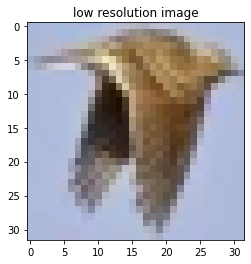

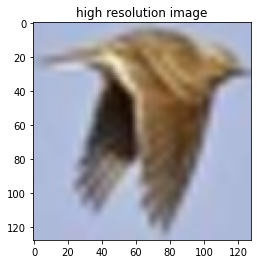

In [10]:
# Load image data
ishape = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Reduce the dataset
train_image = train_images[0:10000]
test_image = test_images[0:1000]

x_train = np.array([img for img in train_image])
x_test = np.array([img for img in test_image])

y_train = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in train_image])
y_test = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in test_image])

# Show an example image
example_idx = 123
plt.figure('LR')
plt.imshow(x_train[example_idx])
plt.title('low resolution image')
plt.figure('HR')
plt.imshow(y_train[example_idx])
plt.title('high resolution image')
plt.show()

In [11]:
# Train the model
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse', metrics=[PSNR, SSIM, 'accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', test_scores[0])
print('Test mse:', test_scores[1])

# Save entire model to a HDF5 file
model.save('FSRCNN.h5')

Epoch 1/10
125/125 [==============================] - 23s 98ms/step - loss: 8604.9590 - PSNR: 10.9308 - SSIM: 0.1872 - accuracy: 0.3768 - val_loss: 1994.3060 - val_PSNR: 15.5800 - val_SSIM: 0.4982 - val_accuracy: 0.4289
Epoch 2/10
125/125 [==============================] - 11s 91ms/step - loss: 1489.6233 - PSNR: 16.9562 - SSIM: 0.5465 - accuracy: 0.4308 - val_loss: 1131.9886 - val_PSNR: 18.0569 - val_SSIM: 0.5853 - val_accuracy: 0.4080
Epoch 3/10
125/125 [==============================] - 12s 98ms/step - loss: 934.1292 - PSNR: 19.0284 - SSIM: 0.6094 - accuracy: 0.4226 - val_loss: 792.3195 - val_PSNR: 19.7450 - val_SSIM: 0.6346 - val_accuracy: 0.4069
Epoch 4/10
125/125 [==============================] - 12s 98ms/step - loss: 713.6870 - PSNR: 20.3418 - SSIM: 0.6520 - accuracy: 0.4311 - val_loss: 650.0321 - val_PSNR: 20.7604 - val_SSIM: 0.6747 - val_accuracy: 0.4313
Epoch 5/10
125/125 [==============================] - 12s 95ms/step - loss: 608.0386 - PSNR: 21.1784 - SSIM: 0.6914 - accura

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


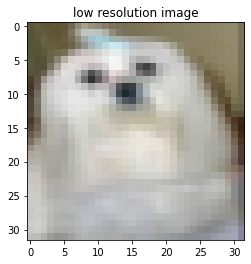

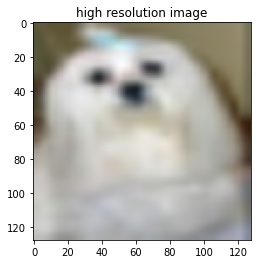

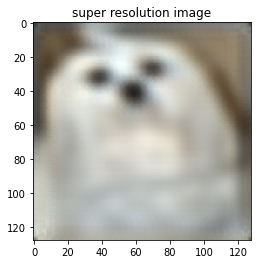

In [12]:
# Set real test image
img = train_images[20001]
lr = np.array(img)
hr = np.array(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC))
test_input = np.reshape(lr, (1, 32, 32, 3))

# Predict a result
sr = model.predict(test_input)
plt.figure('LR')
plt.title('low resolution image')
plt.imshow(lr)
plt.figure('HR')
plt.title('high resolution image')
plt.imshow(hr)
plt.figure('SR')
plt.title('super resolution image')
plt.imshow(sr[0] / 255.0)
plt.show()